In [85]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import tqdm

import torchvision
import torchvision.transforms as transforms 

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [36]:
device = 'cuda' if torch.cuda.is_available() == True else 'cpu'
device

'cuda'

# 데이터 불러오기

In [37]:
cifar100 = torchvision.datasets.CIFAR100(root='./data', 
                                         train=True, 
                                         download=True)

Files already downloaded and verified


In [38]:
dir(cifar100)

['__add__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_integrity',
 '_format_transform_repr',
 '_is_protocol',
 '_load_meta',
 '_repr_indent',
 'base_folder',
 'class_to_idx',
 'classes',
 'data',
 'download',
 'extra_repr',
 'filename',
 'meta',
 'root',
 'target_transform',
 'targets',
 'test_list',
 'tgz_md5',
 'train',
 'train_list',
 'transform',
 'transforms',
 'url']

# 데이터 분할하기

In [52]:
# 7 : 1.5 : 1.5

X_train, X_temp, Y_train, Y_temp = train_test_split(cifar100.data, cifar100.targets, test_size=0.3, random_state=11)

X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=12)



In [40]:
len(v_train)

7500

In [41]:
len(train_y), len(val_y), len(test_y)

NameError: name 'train_y' is not defined

# 데이터 전처리

In [42]:
from torchvision import transforms

train_transform = transforms.Compose([
#     transforms.Resize((32, 32)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)),
])

test_transform = transforms.Compose([
#     transforms.Resize(32, 32),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)),
])

# 데이터셋 & 데이터 로더 생성 

In [49]:
from PIL import Image

class custom_dataset(torch.utils.data.Dataset):
    def __init__(self, x, y, transform):
        self.transform = transform
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        # numpy 배열을 PIL 이미지로 변환
        x = Image.fromarray(self.x[index])
        # 변환 적용
        x = self.transform(x)
        y = self.y[index]
        
        return x, y

In [53]:
train_ds = custom_dataset(X_train, Y_train, transform=train_transform)
val_ds = custom_dataset(X_val, Y_val, transform=test_transform)
test_ds = custom_dataset(X_test, Y_test, transform=test_transform)


In [54]:
print(train_ds.__len__())
print(test_ds.__len__())
print(train_ds.__getitem__(0))
print(test_ds.__getitem__(0))

35000
7500
(tensor([[[-1.2809, -1.2516, -1.2516,  ...,  1.8000,  1.2278, -0.0779],
         [-1.4130, -1.3396, -1.3543,  ...,  1.7706,  1.5799,  0.2889],
         [-1.4423, -1.3249, -1.3690,  ...,  1.7853,  1.7413,  0.7290],
         ...,
         [ 0.9344,  1.6093,  1.6093,  ..., -1.4863, -1.5744, -1.6917],
         [ 1.0077,  1.5946,  1.4479,  ..., -1.6184, -1.4423, -1.3983],
         [ 1.1838,  1.5506,  0.4649,  ..., -1.5890, -1.2809, -1.3543]],

        [[-1.0715, -0.9950, -0.9492,  ...,  1.8498,  1.2992, -0.0468],
         [-1.1939, -1.0715, -1.0562,  ...,  1.8498,  1.7274,  0.3815],
         [-1.2245, -1.0715, -1.0715,  ...,  1.8957,  1.9263,  0.8556],
         ...,
         [ 0.4733,  1.1309,  1.2074,  ..., -1.3927, -1.4845, -1.5915],
         [ 0.6721,  1.2533,  1.1156,  ..., -1.5151, -1.3315, -1.3009],
         [ 0.9627,  1.3451,  0.2438,  ..., -1.4692, -1.1633, -1.2856]],

        [[-0.8580, -0.8012, -0.7728,  ...,  1.5131,  0.9168, -0.2617],
         [-0.9716, -0.8722, -0.85

In [55]:
print(type(X_train))  # X_train의 자료형 확인
print(X_train.shape)  # X_train의 배열 크기 확인
print(type(X_train[0]))  # 첫 번째 이미지의 자료형 확인

<class 'numpy.ndarray'>
(35000, 32, 32, 3)
<class 'numpy.ndarray'>


In [56]:
train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(val_ds, batch_size=32, shuffle=False)

# 모델 구성

In [152]:
for x, y in train_dataloader:
    print(x.shape, y.shape)
    break

torch.Size([32, 3, 32, 32]) torch.Size([32])


In [186]:
class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.linear1 = nn.Linear(64*8*8 , 256)
        self.linear2 = nn.Linear(256,100)
        self.drop = nn.Dropout(p=0.1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.drop(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Convolutional Layer 2
        x = self.conv2(x)
        x = self.drop(x)
        x = self.relu(x)
        x = self.pool(x)

        x = x.view(-1, 64 * 8 * 8)

        x = self.linear1(x)
        x = self.drop(x)
        x = self. linear2(x)
        return x

In [188]:
model = cnn().to(device)
print(model)

cnn(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=4096, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=100, bias=True)
  (drop): Dropout(p=0.1, inplace=False)
)


In [187]:
learning_rate = 0.0005
training_epochs = 15
batch_size = 64

In [189]:
criterion =nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [190]:
from sklearn.metrics import accuracy_score

def train_validate(model, train_dataloader, test_loader, optimizer, loss_func, epochs):
    train_losses = []
    train_accs = []
    validation_losses = []
    validation_accs = []

    for epoch in range(epochs):
        epoch_train_loss = 0.0
        epoch_train_acc = 0.0
        model.train()
        epoch_loss = 0.0
        # 훈련 루프
        for data, target in tqdm.tqdm(train_dataloader):

            data = data.to(device)
            target = target.to(device)
            
            y_pred = model(data)
            # 손실 계산
            loss = loss_func(y_pred, target)
            # Gradient 초기화
            optimizer.zero_grad()
            # 역전파
            loss.backward()
            # 가중치 업데이트
            optimizer.step()
            correct_pred = torch.argmax(y_pred,1) == target
             

            acc = correct_pred.float().mean()

            # 배치 손실 누적
            epoch_loss += loss.item()

            epoch_train_loss += loss.item()
            epoch_train_acc += acc

        # 에포크 당 평균 훈련 손실 및 정확도
        avg_train_loss = epoch_train_loss / len(train_dataloader)
        avg_train_acc = epoch_train_acc / len(train_dataloader)

        train_losses.append(avg_train_loss)
        train_accs.append(avg_train_acc)

        print(f"Epoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}")

        # 검증 루프
        model.eval()
        epoch_validation_loss = 0.0
        with torch.no_grad():
            for data, target in test_loader:
                data = data.to(device)
                target = target.to(device)
                    # 순전파
                y_pred = model(data)
                # 손실계산
                loss = loss_func(y_pred, target)

                
                epoch_validation_loss += loss.item()
        
        avg_validation_loss = epoch_validation_loss / len(test_loader)
        avg_validation_acc = accuracy_score(target.cpu(), y_pred.argmax(dim=1).detach().cpu())
        
        validation_losses.append(avg_validation_loss)
        validation_accs.append(avg_validation_acc)

        print(f"Validation Loss: {avg_validation_loss:.4f}, Validation Acc: {avg_validation_acc:.4f}")

    return train_losses, train_accs, validation_losses, validation_accs

In [191]:
epochs=20

In [192]:
train_losses, train_accs, validation_losses, validation_accs = train_validate(model, train_dataloader, val_dataloader, optimizer, criterion, epochs)

100%|██████████| 1094/1094 [00:11<00:00, 94.95it/s]


Epoch: 1, Train Loss: 3.4492, Train Acc: 0.1945
Validation Loss: 2.9835, Validation Acc: 0.1667


100%|██████████| 1094/1094 [00:12<00:00, 89.06it/s]


Epoch: 2, Train Loss: 2.6127, Train Acc: 0.3492
Validation Loss: 2.6359, Validation Acc: 0.2500


100%|██████████| 1094/1094 [00:12<00:00, 87.95it/s]


Epoch: 3, Train Loss: 2.2189, Train Acc: 0.4323
Validation Loss: 2.4923, Validation Acc: 0.2500


100%|██████████| 1094/1094 [00:12<00:00, 88.44it/s]


Epoch: 4, Train Loss: 1.9026, Train Acc: 0.5019
Validation Loss: 2.4556, Validation Acc: 0.4167


100%|██████████| 1094/1094 [00:12<00:00, 87.49it/s]


Epoch: 5, Train Loss: 1.6332, Train Acc: 0.5651
Validation Loss: 2.4899, Validation Acc: 0.4167


100%|██████████| 1094/1094 [00:13<00:00, 80.06it/s]


Epoch: 6, Train Loss: 1.3893, Train Acc: 0.6189
Validation Loss: 2.5945, Validation Acc: 0.2500


100%|██████████| 1094/1094 [00:13<00:00, 78.75it/s]


Epoch: 7, Train Loss: 1.1650, Train Acc: 0.6734
Validation Loss: 2.7112, Validation Acc: 0.3333


100%|██████████| 1094/1094 [00:12<00:00, 87.08it/s]


Epoch: 8, Train Loss: 0.9844, Train Acc: 0.7173
Validation Loss: 2.8360, Validation Acc: 0.3333


100%|██████████| 1094/1094 [00:12<00:00, 87.12it/s]


Epoch: 9, Train Loss: 0.8228, Train Acc: 0.7574
Validation Loss: 3.0374, Validation Acc: 0.3333


100%|██████████| 1094/1094 [00:13<00:00, 80.65it/s]


Epoch: 10, Train Loss: 0.7052, Train Acc: 0.7880
Validation Loss: 3.2541, Validation Acc: 0.2500


100%|██████████| 1094/1094 [00:13<00:00, 81.32it/s]


Epoch: 11, Train Loss: 0.5914, Train Acc: 0.8205
Validation Loss: 3.4883, Validation Acc: 0.2500


100%|██████████| 1094/1094 [00:13<00:00, 80.25it/s]


Epoch: 12, Train Loss: 0.5250, Train Acc: 0.8385
Validation Loss: 3.6482, Validation Acc: 0.1667


100%|██████████| 1094/1094 [00:14<00:00, 74.53it/s]


Epoch: 13, Train Loss: 0.4729, Train Acc: 0.8519
Validation Loss: 3.7837, Validation Acc: 0.2500


100%|██████████| 1094/1094 [00:15<00:00, 72.87it/s]


Epoch: 14, Train Loss: 0.4198, Train Acc: 0.8669
Validation Loss: 4.0188, Validation Acc: 0.3333


100%|██████████| 1094/1094 [00:15<00:00, 72.64it/s]


Epoch: 15, Train Loss: 0.3969, Train Acc: 0.8736
Validation Loss: 4.0965, Validation Acc: 0.3333


100%|██████████| 1094/1094 [00:14<00:00, 73.13it/s]


Epoch: 16, Train Loss: 0.3649, Train Acc: 0.8847
Validation Loss: 4.2572, Validation Acc: 0.2500


100%|██████████| 1094/1094 [00:14<00:00, 73.04it/s]


Epoch: 17, Train Loss: 0.3407, Train Acc: 0.8913
Validation Loss: 4.3846, Validation Acc: 0.1667


100%|██████████| 1094/1094 [00:13<00:00, 82.71it/s]


Epoch: 18, Train Loss: 0.3205, Train Acc: 0.8964
Validation Loss: 4.5969, Validation Acc: 0.1667


100%|██████████| 1094/1094 [00:12<00:00, 84.65it/s]


Epoch: 19, Train Loss: 0.3029, Train Acc: 0.9038
Validation Loss: 4.6198, Validation Acc: 0.2500


100%|██████████| 1094/1094 [00:12<00:00, 84.56it/s]


Epoch: 20, Train Loss: 0.2925, Train Acc: 0.9063
Validation Loss: 4.8519, Validation Acc: 0.2500


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

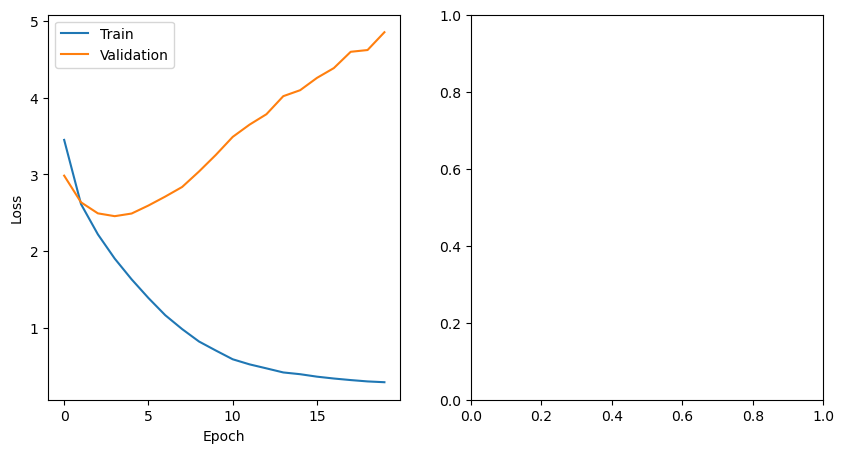

In [193]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train")
plt.plot(validation_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train")
plt.plot(validation_accs, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.show()

In [194]:
torch.save(model.state_dict(), "model.pth")

In [195]:
model.load_state_dict(torch.load("model.pth"))

/tmp/ipykernel_19963/1722216506.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth"))


<All keys matched successfully>

In [196]:
def predict(model, dataloader):
    model.eval()  # 평가 모드로 전환
    all_preds = []

    with torch.no_grad():  # 그래디언트 계산 비활성화
        for data, _ in dataloader:
            data = data.to(device)  # 데이터를 장치로 이동
            
            # 모델 예측
            outputs = model(data)
            preds = outputs.argmax(dim=1)
            
            # 예측값을 리스트에 추가
            all_preds.extend(preds.cpu().numpy())

    return all_preds

In [197]:
preds = predict(model, test_dataloader)

In [198]:
confusion_matrix(Y_test, preds)

array([[50,  0,  1, ...,  1,  0,  0],
       [ 2, 26,  0, ...,  0,  0,  0],
       [ 1,  0, 13, ...,  0,  3,  0],
       ...,
       [ 0,  0,  0, ..., 20,  0,  0],
       [ 1,  0,  1, ...,  0, 24,  0],
       [ 0,  0,  0, ...,  0,  0, 22]])

In [199]:
classification_report(Y_test, preds)

'              precision    recall  f1-score   support\n\n           0       0.59      0.68      0.63        73\n           1       0.39      0.38      0.39        68\n           2       0.25      0.18      0.21        73\n           3       0.14      0.18      0.16        71\n           4       0.17      0.22      0.19        72\n           5       0.44      0.35      0.39        79\n           6       0.28      0.35      0.31        75\n           7       0.38      0.32      0.34        73\n           8       0.49      0.46      0.48        71\n           9       0.46      0.57      0.51        72\n          10       0.22      0.27      0.24        82\n          11       0.13      0.18      0.15        76\n          12       0.37      0.23      0.28        92\n          13       0.32      0.30      0.31        66\n          14       0.26      0.14      0.18        77\n          15       0.29      0.25      0.27        65\n          16       0.30      0.30      0.30        83\n       

In [200]:
accuracy_score(Y_test, preds)

0.3369333333333333

In [201]:
from sklearn.metrics import f1_score, precision_score, recall_score

print(f1_score(Y_test, preds, average="macro"))
print(precision_score(Y_test, preds, average="macro"))
print(recall_score(Y_test, preds, average="macro"))

0.3382432605034512
0.35494112216094353
0.3365288290209007


In [204]:
from torchvision.models import resnet18
resnet = resnet18(pretrained = True)

num_features = resnet.fc.in_features

resnet.fc = nn.Linear(num_features,100)

resnet = resnet.to(device)


/home/ohk446/miniconda3/envs/on_1/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ohk446/miniconda3/envs/on_1/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
